## Leave-One-Out Cross Validation

In this notebook we'll illustrate leave-one-out cross validation using the California housing data. First import the usual packages. We'll also use the seaborn package for visualization -- this has some nice functions that you might want to explore. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline



Now we'll import the California house data.


In [14]:
from sklearn.datasets import fetch_california_housing
ca_housing = fetch_california_housing()
print(ca_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
california = pd.DataFrame(ca_housing.data, columns=ca_housing.feature_names)
california['MedValue'] = ca_housing.target
california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


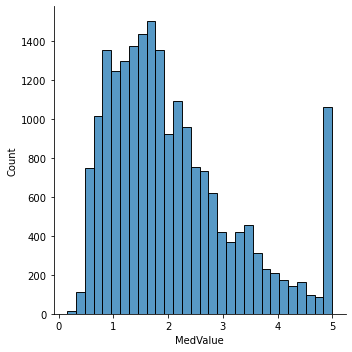

In [4]:
_ = sns.displot(california['MedValue'], bins=30)


Let's look at pairs of selected variables. We'll restrict to the first 1000 entries for efficiency.


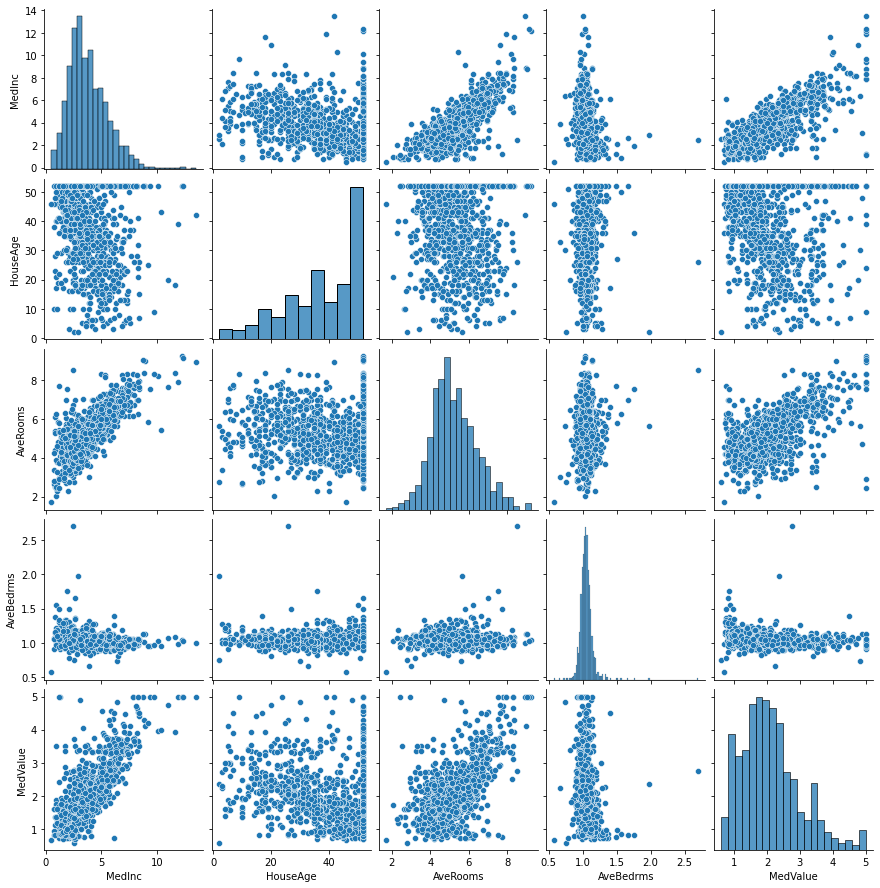

In [7]:
cali = california.head(1000)
cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'MedValue']
sns_plot = sns.pairplot(cali[cols])
sns_plot.savefig("ca_pairplot.png")

We'll now compare three models, using the variable 'MedInc', adding 'AveRooms' and then adding 'HouseAge'


In [8]:
X1 = pd.DataFrame()
X1['MedInc'] = cali['MedInc']
X1 = sm.add_constant(X1) 

X2 = X1.copy()
X2['AveRooms'] = cali['AveRooms']

X3 = X2.copy()
X3['HouseAge'] = cali['HouseAge']

First we'll run cross-validation by taking random training/test splits and averaging the test errors.


In [9]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

y = cali['MedValue']

error1 = []
error2 = []
error3 = []
trials = 200

for trial in np.arange(trials):
    X_train, X_test, y_train, y_test = train_test_split(X1, y, train_size=.50)
    model = sm.OLS(y_train, X_train).fit()
    error1.append(np.mean((y_test - model.predict(X_test))**2))

    X_train, X_test, y_train, y_test = train_test_split(X2, y, train_size=.50)
    model = sm.OLS(y_train, X_train).fit()
    error2.append(np.mean((y_test - model.predict(X_test))**2))

    X_train, X_test, y_train, y_test = train_test_split(X3, y, train_size=.50)
    model = sm.OLS(y_train, X_train).fit()
    error3.append(np.mean((y_test - model.predict(X_test))**2))

print(" Model 1: %f\n Model 2: %f\n Model 3: %f" % (np.mean(error1), np.mean(error2), np.mean(error3)))


 Model 1: 0.325274
 Model 2: 0.330677
 Model 3: 0.326849


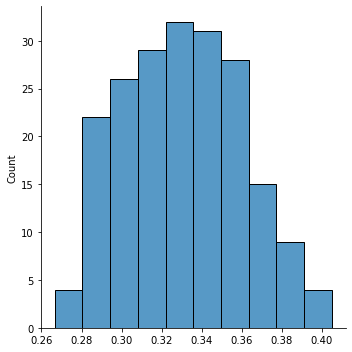

In [10]:
sns_plot = sns.displot(error2)
sns_plot.savefig("ca_error2.png")

Now let's compute leave-one-out cross-validation scores for the three models. Note that this doesn't require any splitting of the data into test and training, we simply fit a single model on *all* of the data.


In [11]:
H1 = np.dot(X1, np.dot(np.linalg.inv(np.dot(X1.T, X1)), X1.T))
yhat = np.dot(H1, y)
loocv1 = np.mean((y-yhat)**2/(1-np.diag(H1))**2)


H2 = np.dot(X2, np.dot(np.linalg.inv(np.dot(X2.T, X2)), X2.T))
yhat = np.dot(H2, y)
loocv2 = np.mean((y-yhat)**2/(1-np.diag(H2))**2)


H3 = np.dot(X3, np.dot(np.linalg.inv(np.dot(X3.T, X3)), X3.T))
yhat = np.dot(H3, y)
loocv3 = np.mean((y-yhat)**2/(1-np.diag(H3))**2)

print(" Model 1 LOOCV: %f\n Model 2 LOOCV: %f\n Model 3 LOOCV: %f" % (loocv1, loocv2, loocv3))


 Model 1 LOOCV: 0.328007
 Model 2 LOOCV: 0.328799
 Model 3 LOOCV: 0.325303


For comparison, let's see what the LOOCV score is if we include all of the variables (9 total)


In [13]:
X = cali.drop('MedValue', axis=1)
X = sm.add_constant(X)
y = cali['MedValue']
model = sm.OLS(y, X).fit()
H = np.dot(X, np.dot(np.linalg.inv(np.dot(X.T, X)), X.T))
yhat = np.dot(H, y)
loocv = np.mean((y-yhat)**2/(1-np.diag(H))**2)
# check that we get the same result with the predicted values
loocv2 = np.mean((y-model.predict(X))**2/(1-np.diag(H))**2)

print(loocv)
print(loocv2)



0.2961411570066513
0.2961411570108704


## Your turn!

Now take 100 samples from the California housing data, and fit a sequence 
of regularized linear regression models using all of the variables. 
Use leave-one-out cross-validation to estimate the mean squared error,
as you vary the regularization parameter. What do you find with the shape 
of the curve?  What happens to the curve as you increase $n=100$ to large
sample sizes?

Suggestion: You can use the code <code>np.diagflat(np.ones(10))</code> to
create a 10x10 (for example) diagonal matrix with all ones on the diagonal
(aka the identity matrix).

